In [ ]:
# ==========================================
# MagicBricks Scraper (Minimal, Professional Dataset)
# - Extracts ONLY strong, high-quality fields
# - No Selenium, only Requests + BeautifulSoup
# ==========================================

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re, time, json

# -------------------------
# CONFIG
# -------------------------
localities = [
    "gachibowli", "kukatpally", "miyapur", "kondapur",
    "kompally", "nallagandla", "tellapur", "bachupally",
    "lb-nagar", "uppal", "attapur", "chandanagar",
    "manikonda", "banjara-hills", "madhapur"
]

pages_per_locality = 7
delay_between_requests = 1
output_csv = "magicbricks_clean_minimal.csv"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

# -------------------------
# HELPERS
# -------------------------
def safe(el):
    return el.get_text(strip=True) if el else None

def parse_price(price_text):
    if not price_text:
        return (None, None, None)
    txt = price_text.replace(",", "")
    nums = re.findall(r'[\d.]+', txt)

    mult = 1
    if "Cr" in txt:
        mult = 1e7
    elif "Lac" in txt or "Lakh" in txt:
        mult = 1e5

    if len(nums) == 1:
        v = float(nums[0]) * mult
        return (v, v, v)
    if len(nums) >= 2:
        v1 = float(nums[0])*mult
        v2 = float(nums[1])*mult
        return (min(v1,v2), max(v1,v2), (v1+v2)/2)
    return (None, None, None)

def parse_price_psf(text):
    if not text:
        return None
    nums = re.findall(r'[\d,]+', text)
    return float(nums[0].replace(",", "")) if nums else None

def extract_area(card):
    area_el = card.find(attrs={"data-summary":"super-area"})
    if area_el:
        val = area_el.find(class_=re.compile("value"))
        if val:
            t = safe(val)
            m = re.search(r'([\d,]+)\s*sq', t)
            if m:
                num = float(m.group(1).replace(",", ""))
                return (f"{int(num)} sqft", num)
    # fallback search
    possible = card.find_all(string=re.compile(r'sq', re.I))
    if possible:
        txt = possible[0]
        m = re.search(r'([\d,]+)\s*sq', txt)
        if m:
            num = float(m.group(1).replace(",", ""))
            return (f"{int(num)} sqft", num)
    return (None, None)

def extract_summary(card, labels):
    items = card.select(".mb-srp__card__summary__list--item")
    for it in items:
        lab = it.find(class_=re.compile("label"))
        val = it.find(class_=re.compile("value"))
        if not lab or not val:
            continue
        l = lab.get_text(strip=True).lower()
        for k in labels:
            if k.lower() in l:
                return val.get_text(strip=True)
    return None

# -------------------------
# SCRAPE LOOP
# -------------------------
records = []

for loc in localities:
    print(f"\n🏙️ Locality: {loc}")
    for page in range(1, pages_per_locality+1):
        url = f"https://www.magicbricks.com/property-for-sale-in-{loc}-hyderabad-pppfs?page={page}"
        r = requests.get(url, headers=headers)
        if r.status_code != 200:
            print("⚠️ Page error", r.status_code)
            time.sleep(delay_between_requests)
            continue

        soup = BeautifulSoup(r.text, "html.parser")
        cards = [
            c for c in soup.find_all("div", class_=re.compile("mb-srp__card"))
            if c.find(class_=re.compile("title")) and c.find(class_=re.compile("price"))
        ]

        print(f"  🔸 Page {page} → {len(cards)} listings")

        for card in cards:
            try:
                title = safe(card.find(class_=re.compile("title")))
                price_text = safe(card.find(class_=re.compile("price--amount")))
                pp_text = safe(card.find(class_=re.compile("price--size")))
                price_min, price_max, price_avg = parse_price(price_text)
                price_psf = parse_price_psf(pp_text)

                # Compute fallback PSF
                area_txt, area_clean = extract_area(card)
                if area_clean and price_avg and not price_psf:
                    price_psf = round(price_avg / area_clean, 2)

                # BHK Detection
                bhk = None
                if title:
                    m = re.search(r'(\d+)\s*BHK', title)
                    if m:
                        bhk = int(m.group(1))

                furnishing = extract_summary(card, ["Furnishing"])
                if furnishing:
                    furnishing = furnishing.replace("Furnishing", "").strip() or None

                parking = extract_summary(card, ["Parking"])
                bathrooms = extract_summary(card, ["Bath"])

                transaction = extract_summary(card, ["Transaction"])

                desc_el = card.find(class_=re.compile("desc"))
                desc = None
                if desc_el:
                    p = desc_el.find("p")
                    if p:
                        desc = safe(p)

                # Property Type
                ptype = "Apartment"
                if title:
                    if re.search(r'villa|independent', title, re.I):
                        ptype = "Independent/Villa"

                # Locality
                locality_clean = loc.replace("-", " ").title()

                records.append({
                    "Title": title,
                    "Property_Type": ptype,
                    "BHK": bhk,
                    "Price_Min": price_min,
                    "Price_Max": price_max,
                    "Price_Avg": price_avg,
                    "Price_per_sqft": price_psf,
                    "Area_Text": area_txt,
                    "Area_Clean": area_clean,
                    "Furnishing": furnishing,
                    "Parking": parking,
                    "Bathrooms": bathrooms,
                    "Transaction_Type": transaction,
                    "Locality": locality_clean,
                    "Description": desc
                })

            except Exception:
                continue

        time.sleep(delay_between_requests)

# -------------------------
# SAVE OUTPUT
# -------------------------
df = pd.DataFrame(records)
df.drop_duplicates(inplace=True)

df.to_csv(output_csv, index=False)
print(f"\n✅ DONE. Saved {len(df)} rows → {output_csv}")



🏙️ Locality: gachibowli
  🔸 Page 1 → 30 listings
  🔸 Page 2 → 30 listings
  🔸 Page 3 → 30 listings
  🔸 Page 4 → 30 listings
  🔸 Page 5 → 30 listings
  🔸 Page 6 → 30 listings
  🔸 Page 7 → 30 listings

🏙️ Locality: kukatpally
  🔸 Page 1 → 30 listings
  🔸 Page 2 → 30 listings
  🔸 Page 3 → 30 listings
  🔸 Page 4 → 30 listings
  🔸 Page 5 → 30 listings
  🔸 Page 6 → 30 listings
  🔸 Page 7 → 30 listings

🏙️ Locality: miyapur
  🔸 Page 1 → 30 listings
  🔸 Page 2 → 30 listings
  🔸 Page 3 → 30 listings
  🔸 Page 4 → 30 listings
  🔸 Page 5 → 30 listings
  🔸 Page 6 → 30 listings
  🔸 Page 7 → 30 listings

🏙️ Locality: kondapur
  🔸 Page 1 → 30 listings
  🔸 Page 2 → 30 listings
  🔸 Page 3 → 30 listings
  🔸 Page 4 → 30 listings
  🔸 Page 5 → 30 listings
  🔸 Page 6 → 30 listings
  🔸 Page 7 → 30 listings

🏙️ Locality: kompally
  🔸 Page 1 → 30 listings
  🔸 Page 2 → 30 listings
  🔸 Page 3 → 30 listings
  🔸 Page 4 → 30 listings
  🔸 Page 5 → 30 listings
  🔸 Page 6 → 30 listings
  🔸 Page 7 → 30 listings

🏙️ Loc

In [ ]:
import pandas as pd

df = pd.read_csv("magicbricks_clean_minimal.csv")

# --- Fix Parking (remove commas, trim) ---
df["Parking"] = (
    df["Parking"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
df.loc[df["Parking"]=="", "Parking"] = None

# --- Clean unicode issues from Description ---
df["Description"] = (
    df["Description"]
    .astype(str)
    .str.encode("utf-8", "ignore")
    .str.decode("utf-8")
)

# --- Convert bathroom count to int safely ---
df["Bathrooms"] = pd.to_numeric(df["Bathrooms"], errors="coerce").astype("Int64")
# Clean title
df["Title"] = df["Title"].str.strip()

# Clean furnishing (None, "", NaN)
df["Furnishing"] = df["Furnishing"].replace(["", "None", "nan"], None)

# Drop rows with no BHK or no Price
df = df.dropna(subset=["BHK", "Price_Avg"])

# Ensure Area_Clean is numeric
df["Area_Clean"] = pd.to_numeric(df["Area_Clean"], errors="coerce")

# Save clean version
df.to_csv("magicbricks_final_ready1.csv", index=False)

df.head()


,Title,Property_Type,BHK,Price_Min,Price_Max,Price_Avg,Price_per_sqft,Area_Text,Area_Clean,Furnishing,Parking,Bathrooms,Transaction_Type,Locality,Description
0,2 BHK Apartment for Sale in Gachibowli Hyderab...,Apartment,2.0,14900000.0,14900000.0,14900000.0,10567.0,1234 sqft,1234.0,Unfurnished,nan,2,Resale,Gachibowli,"2 BHK Apartment for Sale in Kondapur, Hyderaba..."
1,3 BHK Apartment for Sale in Gachibowli Hyderabad,Apartment,3.0,25200000.0,25200000.0,25200000.0,9000.0,2044 sqft,2044.0,Unfurnished,2 Covered,4,Resale,Gachibowli,Embrace a premium lifestyle with this immacula...
2,2 BHK Apartment for Sale in Gachibowli Hyderabad,Apartment,2.0,8890000.0,8890000.0,8890000.0,7111.0,1200 sqft,1200.0,Semi-Furnished,1 Covered,2,Resale,Gachibowli,Property DetailsThis impressive 2 BHK apartmen...
3,4 BHK Apartment for Sale in Gachibowli Hyderab...,Apartment,4.0,55000000.0,55000000.0,55000000.0,11066.0,4970 sqft,4970.0,Furnished,4 Covered,5,Resale,Gachibowli,This spacious 4 BHK apartment is located in th...
4,4 BHK Apartment for Sale in Gachibowli Hyderab...,Apartment,4.0,42900000.0,42900000.0,42900000.0,15889.0,2525 sqft,2525.0,Furnished,3 Covered,3,Resale,Gachibowli,Luxurious 4 BHK Apartment for Sale in Meenaksh...


In [ ]:
import pandas as pd

df = pd.read_csv("/content/magicbricks_final_ready1.csv")

df.info()
df.describe(include='all')
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2725 non-null   object 
 1   Property_Type     2725 non-null   object 
 2   BHK               2725 non-null   float64
 3   Price_Min         2725 non-null   float64
 4   Price_Max         2725 non-null   float64
 5   Price_Avg         2725 non-null   float64
 6   Price_per_sqft    2724 non-null   float64
 7   Area_Text         2719 non-null   object 
 8   Area_Clean        2719 non-null   float64
 9   Furnishing        2702 non-null   object 
 10  Parking           866 non-null    object 
 11  Bathrooms         2705 non-null   float64
 12  Transaction_Type  2723 non-null   object 
 13  Locality          2725 non-null   object 
 14  Description       2725 non-null   object 
dtypes: float64(7), object(8)
memory usage: 319.5+ KB


,Title,Property_Type,BHK,Price_Min,Price_Max,Price_Avg,Price_per_sqft,Area_Text,Area_Clean,Furnishing,Parking,Bathrooms,Transaction_Type,Locality,Description
0,2 BHK Apartment for Sale in Gachibowli Hyderab...,Apartment,2.0,14900000.0,14900000.0,14900000.0,10567.0,1234 sqft,1234.0,Unfurnished,NaN,2.0,Resale,Gachibowli,"2 BHK Apartment for Sale in Kondapur, Hyderaba..."
1,3 BHK Apartment for Sale in Gachibowli Hyderabad,Apartment,3.0,25200000.0,25200000.0,25200000.0,9000.0,2044 sqft,2044.0,Unfurnished,2 Covered,4.0,Resale,Gachibowli,Embrace a premium lifestyle with this immacula...
2,2 BHK Apartment for Sale in Gachibowli Hyderabad,Apartment,2.0,8890000.0,8890000.0,8890000.0,7111.0,1200 sqft,1200.0,Semi-Furnished,1 Covered,2.0,Resale,Gachibowli,Property DetailsThis impressive 2 BHK apartmen...
3,4 BHK Apartment for Sale in Gachibowli Hyderab...,Apartment,4.0,55000000.0,55000000.0,55000000.0,11066.0,4970 sqft,4970.0,Furnished,4 Covered,5.0,Resale,Gachibowli,This spacious 4 BHK apartment is located in th...
4,4 BHK Apartment for Sale in Gachibowli Hyderab...,Apartment,4.0,42900000.0,42900000.0,42900000.0,15889.0,2525 sqft,2525.0,Furnished,3 Covered,3.0,Resale,Gachibowli,Luxurious 4 BHK Apartment for Sale in Meenaksh...


In [ ]:
df.isnull().sum()


,0
Title,0
Property_Type,0
BHK,0
Price_Min,0
Price_Max,0
Price_Avg,0
Price_per_sqft,1
Area_Text,6
Area_Clean,6
Furnishing,23


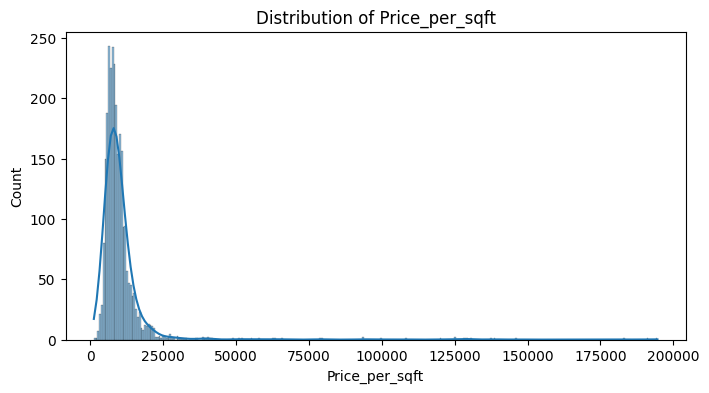

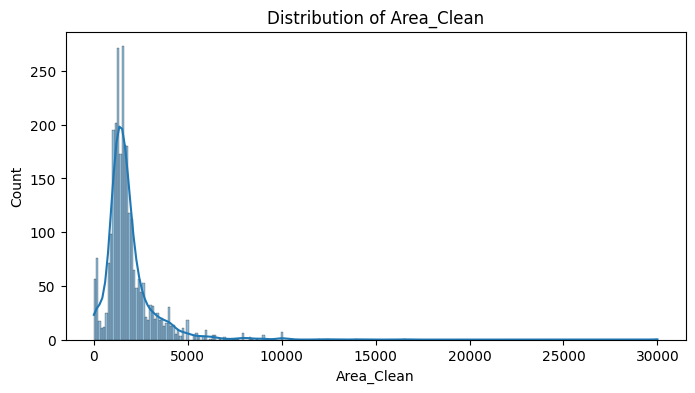

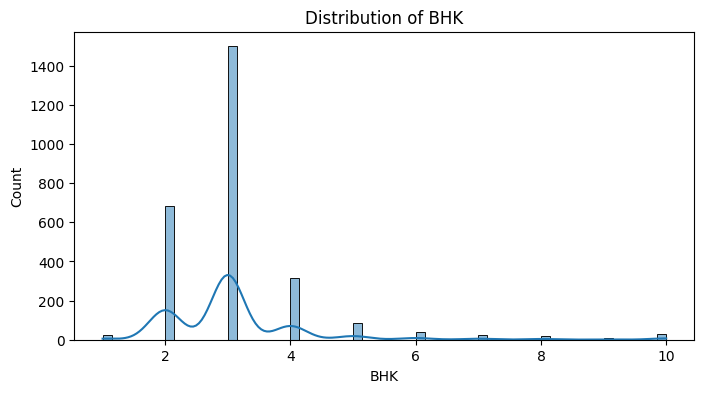

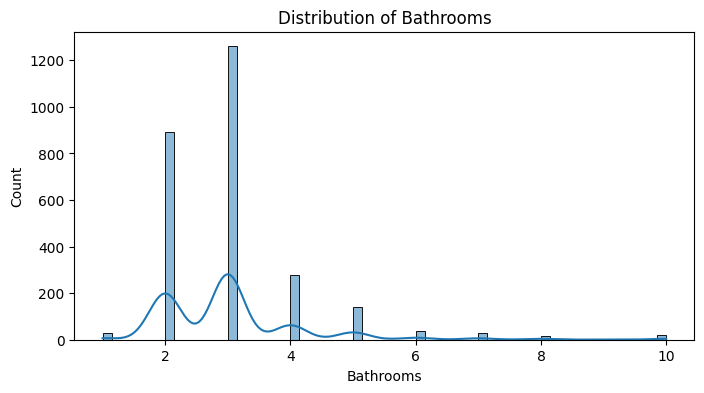

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ["Price_per_sqft", "Area_Clean", "BHK", "Bathrooms"]

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


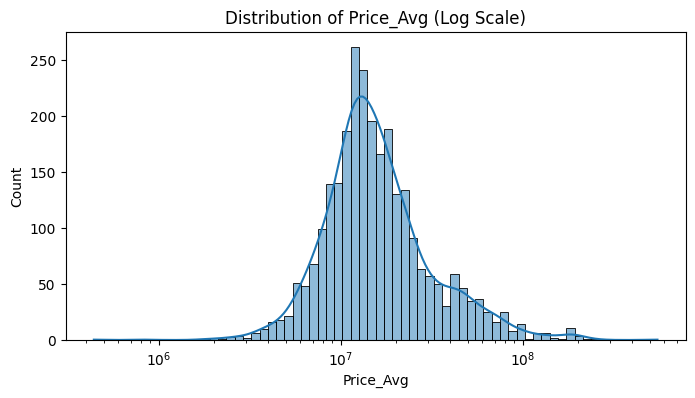

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["Price_Avg"], kde=True, log_scale=True)
plt.title("Distribution of Price_Avg (Log Scale)")
plt.show()


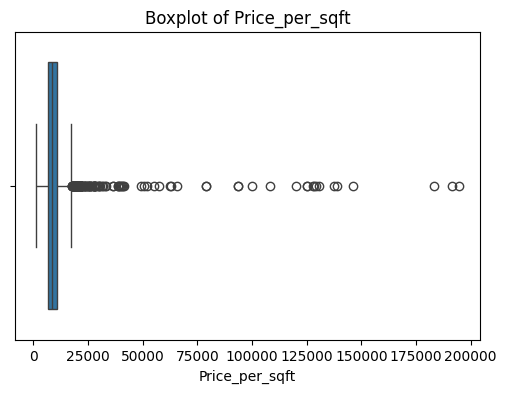

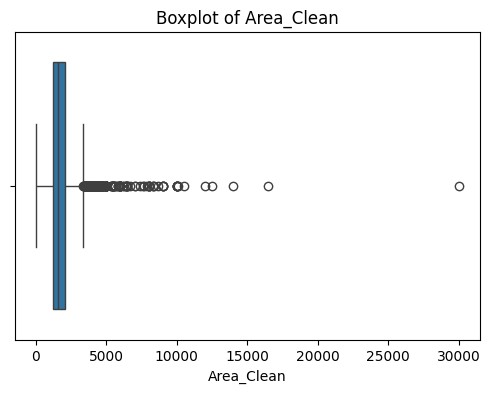

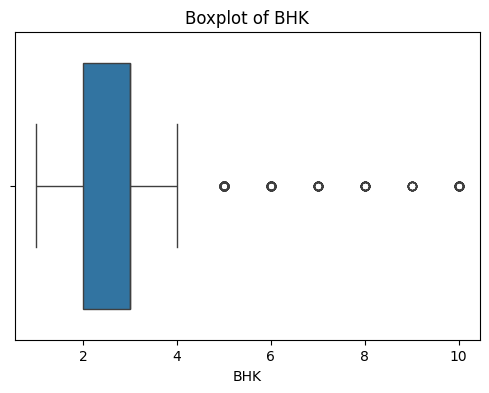

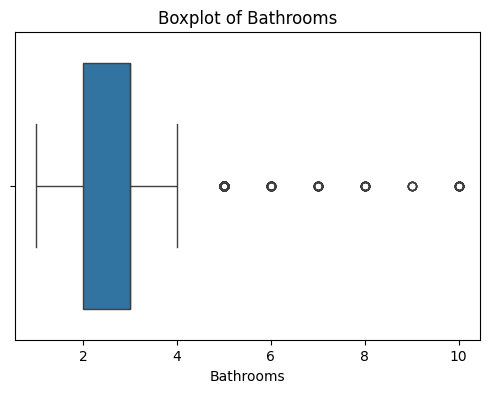

In [ ]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


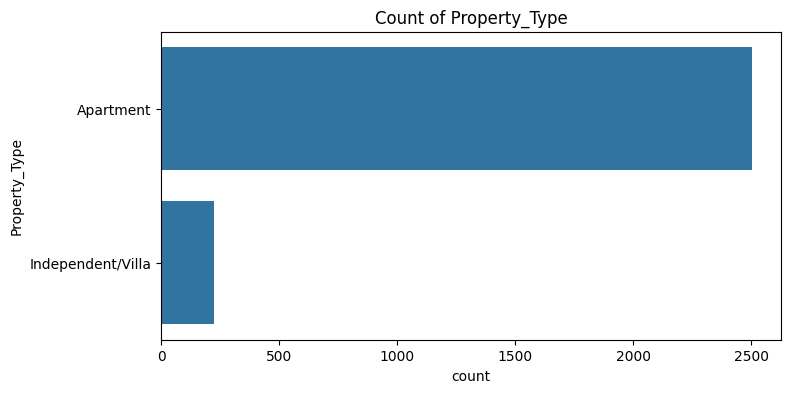

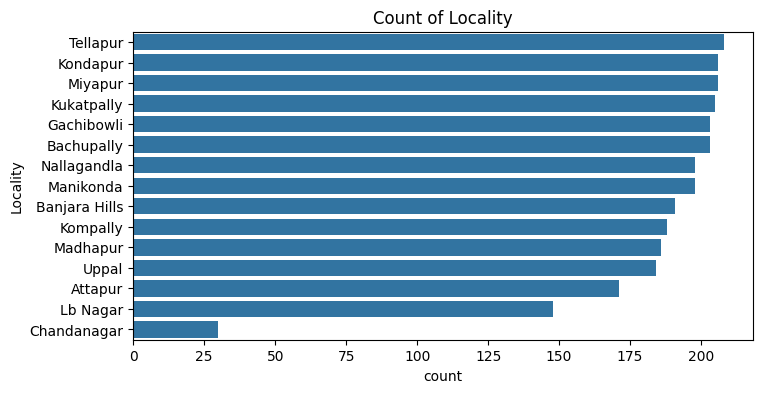

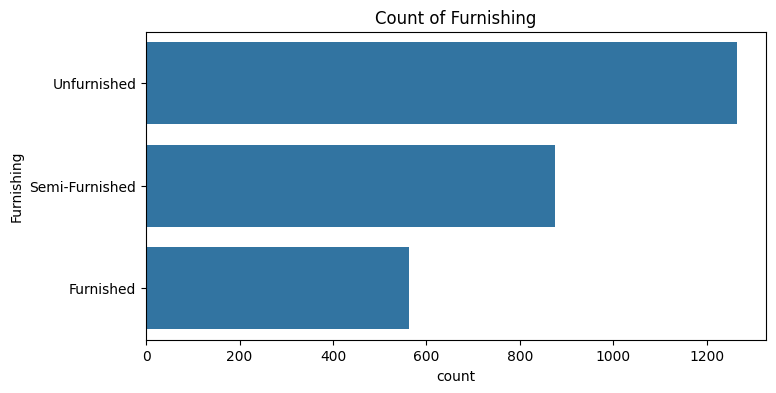

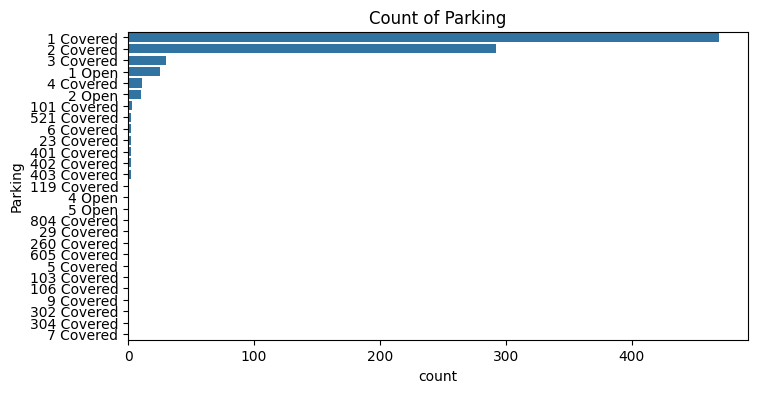

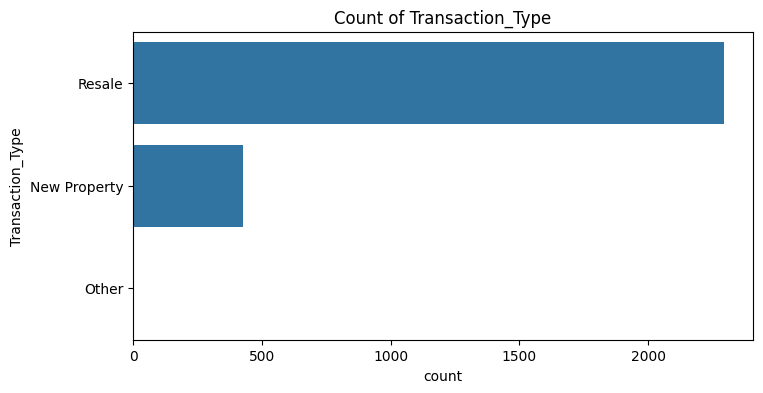

In [ ]:
cat_cols = ["Property_Type","Locality","Furnishing","Parking","Transaction_Type"]

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.show()


**Bi Variate Analysis**


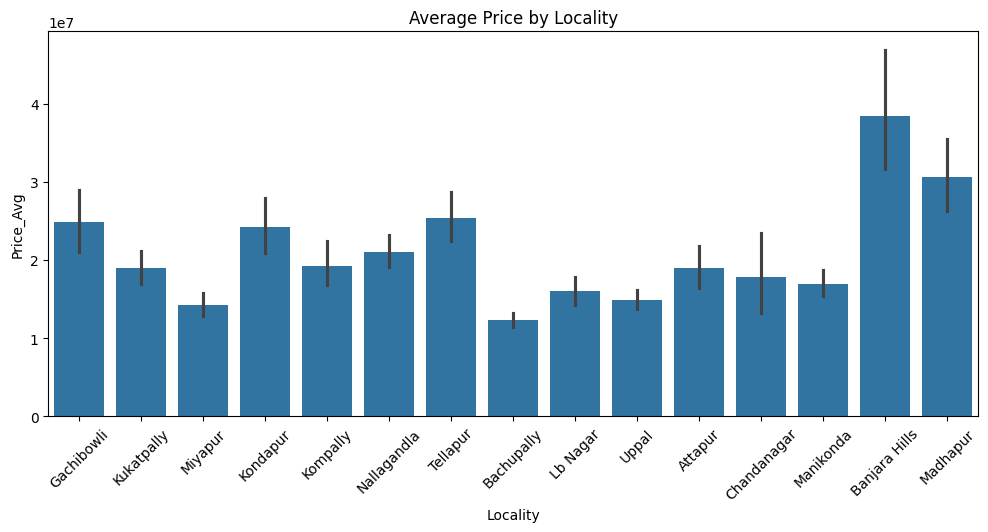

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x="Locality", y="Price_Avg", data=df)
plt.xticks(rotation=45)
plt.title("Average Price by Locality")
plt.show()


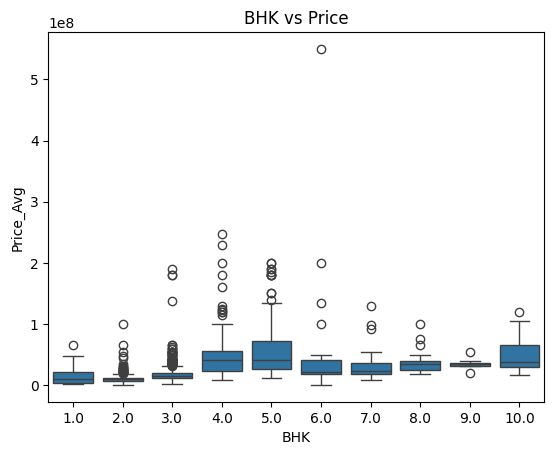

In [ ]:
sns.boxplot(x="BHK", y="Price_Avg", data=df)
plt.title("BHK vs Price")
plt.show()


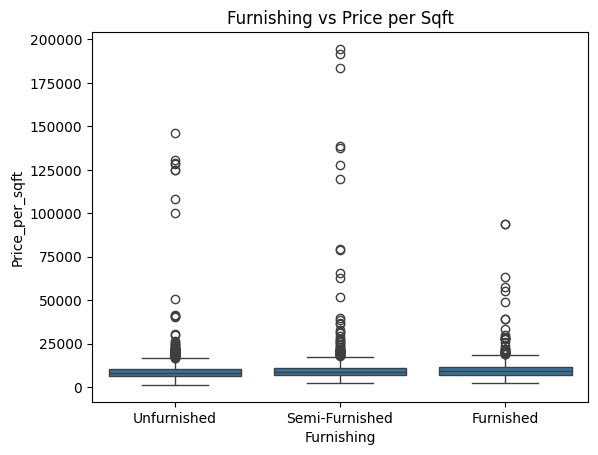

In [ ]:
sns.boxplot(x="Furnishing", y="Price_per_sqft", data=df)
plt.title("Furnishing vs Price per Sqft")
plt.show()


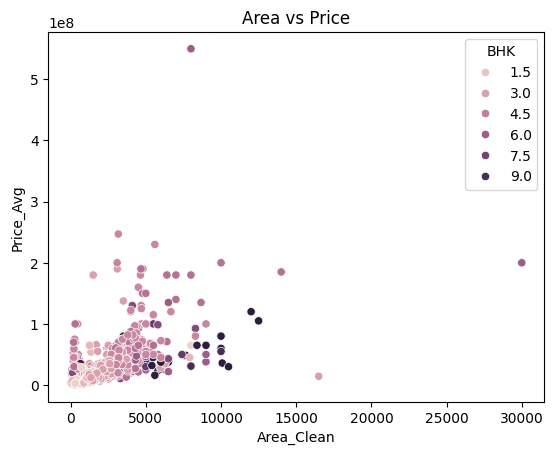

In [ ]:
sns.scatterplot(x="Area_Clean", y="Price_Avg", hue="BHK", data=df)
plt.title("Area vs Price")
plt.show()


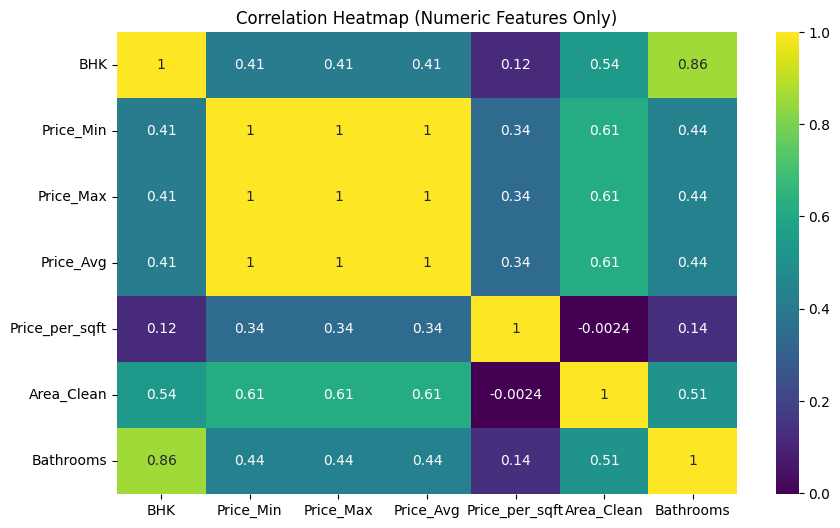

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


**Multi Variate Analysis**

Property_Type     Apartment  Independent/Villa
Locality                                      
Attapur        1.597713e+07       5.236429e+07
Bachupally     1.045397e+07       2.666250e+07
Banjara Hills  3.723443e+07       6.618750e+07
Chandanagar    1.605714e+07       4.250000e+07
Gachibowli     2.110222e+07       1.052222e+08
Kompally       1.226958e+07       4.084348e+07
Kondapur       2.002553e+07       1.162222e+08
Kukatpally     1.836617e+07       5.125000e+07
Lb Nagar       1.581720e+07       2.270000e+07
Madhapur       2.550345e+07       1.051000e+08
Manikonda      1.491935e+07       4.631538e+07
Miyapur        1.279872e+07       4.360000e+07
Nallagandla    1.751579e+07       6.451333e+07
Tellapur       1.608209e+07       5.903556e+07
Uppal          1.475551e+07       1.968333e+07


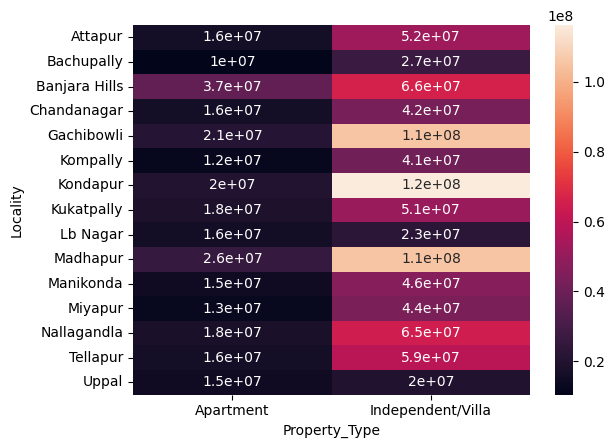

In [ ]:
pivot = df.pivot_table(values="Price_Avg", index="Locality", columns="Property_Type", aggfunc="mean")
print(pivot)
sns.heatmap(pivot, annot=True)
plt.show()
